In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

N = 30
T = 20

U = np.random.rand(N, T)
bins = np.array([1/3, 2/3])  
idx = np.digitize(U, bins)   #
levels = np.array([0.33, 0.66, 1.00])
X_raw = levels[idx]     

t = np.sum(np.isclose(X_raw, 0.33), axis=1)     

X = np.isclose(X_raw, 0.33).astype(float)       

print("X_raw shape:", X_raw.shape)
print("X shape:", X.shape)
print("t shape:", t.shape)
print("Przykładowy target:", t[:5])


X_raw shape: (30, 20)
X shape: (30, 20)
t shape: (30,)
Przykładowy target: [ 9  7 10  5  4]


In [4]:
def update_state(xk, sk, wx, wRec):
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(X.shape[1]):
        S[:, k+1] = update_state(X[:, k], S[:, k], wx, wRec)
    return S

def loss(y, t):
    return np.mean((t - y)**2)


In [5]:
def output_gradient(y, t):
    return 2.0 * (y - t) / y.shape[0]

def backward_gradient(X, S, grad_out, wRec):
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out

    wx_grad = 0.0
    wRec_grad = 0.0

    for k in range(X.shape[1], 0, -1):
        wx_grad   += np.sum(grad_over_time[:, k] * X[:, k-1])
        wRec_grad += np.sum(grad_over_time[:, k] * S[:, k-1])

        grad_over_time[:, k-1] = grad_over_time[:, k] * wRec

    return (wx_grad, wRec_grad), grad_over_time


In [6]:
def grad_check(X, t, wx, wRec, eps=1e-7):
    # 
    S = forward_states(X, wx, wRec)
    y = S[:, -1]
    g_out = output_gradient(y, t)
    (g_wx, g_wRec), _ = backward_gradient(X, S, g_out, wRec)

    #  wx
    lp = loss(forward_states(X, wx+eps, wRec)[:, -1], t)
    lm = loss(forward_states(X, wx-eps, wRec)[:, -1], t)
    g_wx_num = (lp - lm) / (2*eps)

    lp = loss(forward_states(X, wx, wRec+eps)[:, -1], t)
    lm = loss(forward_states(X, wx, wRec-eps)[:, -1], t)
    g_wRec_num = (lp - lm) / (2*eps)

    print("wx:  ana =", g_wx,   " num =", g_wx_num,   " abs diff =", abs(g_wx-g_wx_num))
    print("wRec: ana =", g_wRec," num =", g_wRec_num, " abs diff =", abs(g_wRec-g_wRec_num))

grad_check(X, t, wx=1.2, wRec=1.2)


wx:  ana = 11951.289071024317  num = 11951.289084208838  abs diff = 1.3184520867071114e-05
wRec: ana = 181975.32600306143  num = 181975.3261133883  abs diff = 0.00011032685870304704


Final: wx=1.0184, wRec=0.9982, loss=0.000513


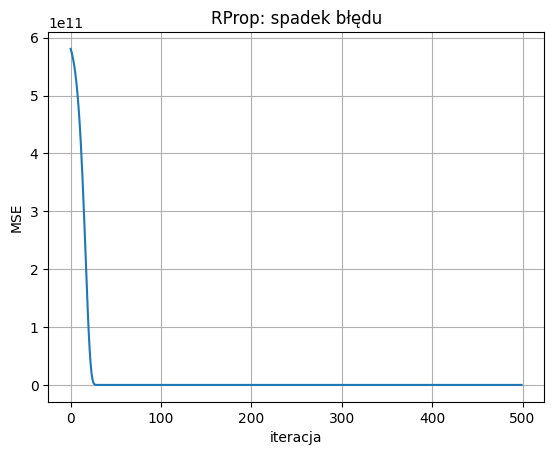

In [7]:
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p=1.2, eta_n=0.5):
    wx, wRec = W

    S = forward_states(X, wx, wRec)
    y = S[:, -1]
    g_out = output_gradient(y, t)
    (g_wx, g_wRec), _ = backward_gradient(X, S, g_out, wRec)

    grads = np.array([g_wx, g_wRec])
    sign = np.sign(grads)

    for i in range(2):
        if sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n

    return W_delta, sign, grads, loss(y, t)

# init
W = np.array([-1.5, 2.0], dtype=float)        # [wx, wRec]
W_delta = np.array([0.001, 0.001], dtype=float)
W_sign = np.array([0.0, 0.0], dtype=float)

hist_W = [tuple(W)]
hist_L = []

for i in range(500):
    W_delta, W_sign, grads, L = update_rprop(X, t, W, W_sign, W_delta)
    W = W - W_sign * W_delta
    hist_W.append(tuple(W))
    hist_L.append(L)

print(f"Final: wx={W[0]:.4f}, wRec={W[1]:.4f}, loss={hist_L[-1]:.6f}")

plt.figure()
plt.plot(hist_L)
plt.title("RProp: spadek błędu")
plt.xlabel("iteracja")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


In [8]:
def make_one_sequence(T=20):
    u = np.random.rand(T)
    idx = np.digitize(u, np.array([1/3, 2/3]))
    raw = np.array([0.33, 0.66, 1.0])[idx]
    x = np.isclose(raw, 0.33).astype(float)
    target = int(np.sum(x))
    return raw, x, target

raw, x, target = make_one_sequence(T)
S = forward_states(x.reshape(1,-1), W[0], W[1])
pred = S[0, -1]

print("raw:", raw)
print("target count(0.33):", target)
print("model output:", pred, " -> zaokrąglone:", int(np.round(pred)))


raw: [1.   1.   0.33 0.33 0.33 1.   1.   0.66 0.33 1.   0.66 1.   1.   0.66
 0.33 1.   0.33 0.33 0.66 0.66]
target count(0.33): 7
model output: 7.004866499996354  -> zaokrąglone: 7
